In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [2]:
# read in flow cytometry data
culture_data=pd.read_csv('data/zinser_figure2a.csv')
psd_data=pd.read_csv('data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

In [3]:
# helper function to fill shading for "nights"
def plot_night_day(ax, ylims):
    # fill uin shading
    ax.fill_between(ten_days['hour'], 0, 1, 
                    where=ten_days['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
    # set y limits
    ax.set_ylim(ylims[0],ylims[1])
    # hide y ticks
    ax.tick_params(left=False, labelleft=False, top=False, labeltop=False,
                   right=False, labelright=False, bottom=False, labelbottom=False)

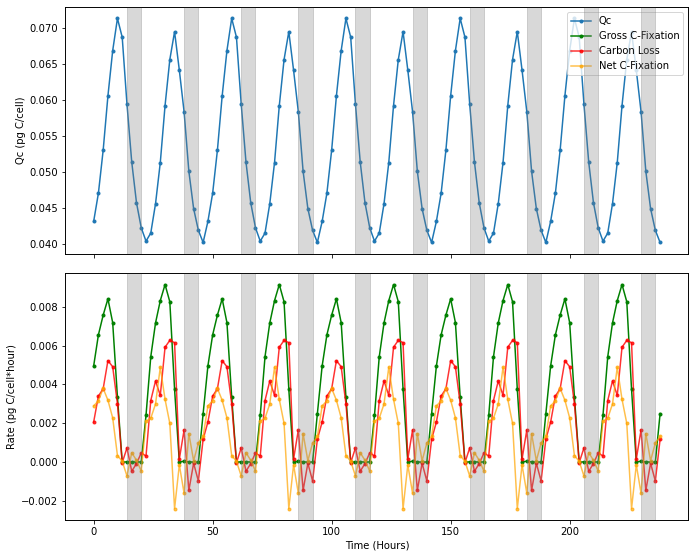

In [4]:
# create 10 day simulated data for Qc data
ten_days=pd.concat([pro_data[:-1]]*5).reset_index().drop(columns=['index'])
# reformat hour column to represent new, simulated time
ten_days['hour']=np.arange(0,len(ten_days)*2,2)

#### Plot to check if simulation successful ####
# create figure
fig,axs=plt.subplots(figsize=(10,8), nrows=2,sharex=True)
# plot hourly Qc
ln0=axs[0].plot(ten_days['hour'],ten_days['Qc_hour'],marker='.', label='Qc')
# set labels and titles
axs[0].set_ylabel('Qc (pg C/cell)')
# set up secondary axis
twinax=axs[0].twinx()
# plot night and day for secondary axis in top subplot
plot_night_day(twinax, (-0.00075,0.01))

# plot Gross PP in bottom subplot
ln1=axs[1].plot(ten_days['hour'],ten_days['GPP'],marker='.', label='Gross C-Fixation', c='g')
# plot C-loss
ln2=axs[1].plot(ten_days['hour'],ten_days['carbonloss'],marker='.', label='Carbon Loss', c='red',alpha=0.8)
# plot net PP
ln3=axs[1].plot(ten_days['hour'],ten_days['NPP'],
            marker='.', label='Net C-Fixation', c='orange',alpha=0.7)

# plot day night
twinax=axs[1].twinx()
# plot night and day for secondary axis in top subplot
plot_night_day(twinax, (-0.00075,0.01))

# create combined legend for all components 
lns=ln0+ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[0].legend(lns,labs,loc='upper right')
# axis labels
axs[1].set_xlabel('Time (Hours)')
axs[1].set_ylabel('Rate (pg C/cell*hour)')

plt.rcParams.update({'font.size':15})
plt.tight_layout()

### Randomly remove data 
Try with varying percentages of missing data

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import compress, product
import math
from random import sample

# helper function to iteratively look for missing data (from Züfle et al. 2020 paper)
## edge cases: edges where forward/back pattern is also missing
def iteratively_impute(sub_df, col):
    # set cutoff for max index
    cutoff=np.max(sub_df.index)
    # iteratively impute missing data 
    for index, row in sub_df.iterrows():
        # check if missing
        if math.isnan(row[col]):
            # index 24 hours before
            back_ind=index-24
            # index 24 hours after
            fwd_ind=index+24
            # get current trend
            trend_curr = sub_df.loc[index,'trend']
            # if neither exist, skip row (fill with l-int. later)
            if (back_ind<0)&(fwd_ind>=cutoff):
                continue
            # if 24 hours before doesn't exist or is missing, only use back
            elif (back_ind<0):
                diam_smooth=sub_df.loc[fwd_ind, col]
                trend_factor=sub_df.loc[fwd_ind,'trend']
            # if 24 hours after doesn't exist or is missing, only only use fwd
            elif fwd_ind>=len(sub_df):
                diam_smooth=sub_df.loc[back_ind, col]
                trend_factor=sub_df.loc[back_ind,'trend']
            # if both exist, take the average (ignorning nan)
            else:
                diam_smooth=np.nanmean([sub_df.loc[fwd_ind, col],sub_df.loc[back_ind, col]])
                trend_factor=trend_curr

            diam_pred=(trend_curr/trend_factor)*diam_smooth
            sub_df.loc[index,col]=diam_pred
            # set filled flag
            sub_df.loc[index,'filled']=1
        # not missing
        else:
            # set filled flag if not missing
            sub_df.loc[index,'filled']=1
    return(sub_df)

## helper function to generate missing data from Qc column
# inputs: df=dataframe with "Qc_hourly" column, p = float that specifies % of data to remove
# returns: missing_data=data_frame with new column with data removed
def generate_missing_data(df, p):
    # make copy of dataframe 
    missing_data=df.copy()
    # grab hourly Qc only
    qc_only=missing_data[['Qc_hour']]
    # calculate number of nans to add to data
    n = int(qc_only.shape[0]*p)
    # randomly sample to get indices to remove data
    ids = sample(list(product(range(qc_only.shape[0]), range(qc_only.shape[1]))), n)
    # grab indices of missing data
    idx, idy = list(zip(*ids))
    # reshape data to numpy
    data=qc_only.to_numpy().astype(float)
    # update numpy view with np.nan
    data[idx,idy]=np.nan
    # store column with missing data in dataframe
    missing_data['with_missing']=data
    # add population column
    missing_data['pop']='prochloro'
    return(missing_data)

## helper function to run imputation function and fill in data
# input: missing_df=dataframe with 'with_missing' column with data removed
# returns: final_impute=dataframe with imputed data in 'with_missing'
def run_imputation(missing_df):
    # create subsetted df excluding nan values 
    missing_cont=missing_df.loc[missing_df['with_missing'].notna()]

    # run seasonal decomposition on raw data and drop nan values for now
    train=missing_cont['with_missing']
    decompose=seasonal_decompose(train, model='multiplicative', period=24, extrapolate_trend='freq')
    #get trend and seasonal components
    missing_cont.loc[train.index, 'trend']=decompose.trend
    missing_cont.loc[train.index, 'seasonal']=decompose.seasonal

    # set index as time for interpolation
    missing_cont.set_index('hour',inplace=True)
    # grab first and last hours of complete dataframe
    hour_range=missing_25.iloc[[0,-1]]['hour'].values
    # create resamppled list 
    resampled=np.arange(hour_range[0],hour_range[1]+1, 2)
    # resample interpolated list
    missing_resamp = missing_cont.reindex(missing_cont.index.union(
        resampled)).interpolate('values',limit_direction='both').loc[resampled]
    # add missing diam_med data back to interpolated data
    missing_resamp['with_missing']=missing_cont['with_missing']

    # add flag to check if filled
    missing_resamp['filled']=0
    # iteratively impute
    pre_impute =iteratively_impute(missing_resamp, 'with_missing')
    # fill additional gaps with linear interpolation
    final_impute = pre_impute.reindex(pre_impute.index.union(
        resampled)).interpolate(limit_direction='both',axis=0).loc[resampled].reset_index()
    # replace altered with its original values
    final_impute['Qc_hour']=missing_25['Qc_hour']
    final_impute['NPP']=missing_25['NPP']
    final_impute['par']=missing_25['par']
    return(final_impute)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


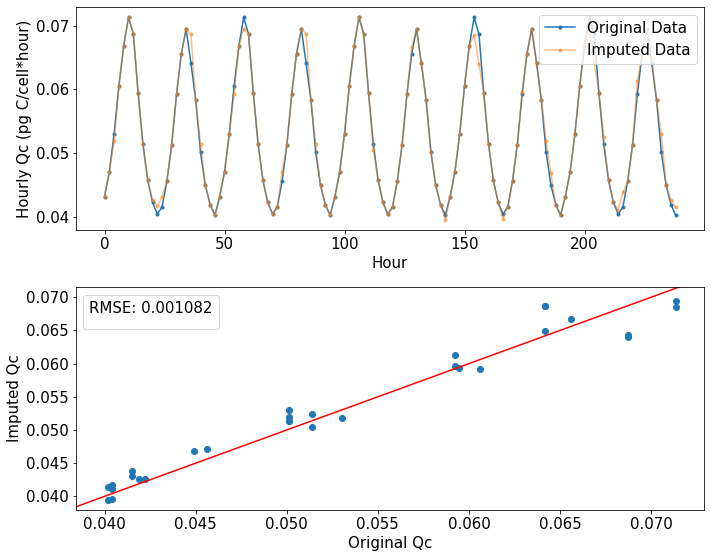

In [6]:
from sklearn.metrics import mean_squared_error
# generate missing data
missing_25=generate_missing_data(ten_days, 0.25)
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
# plot missing filled data with truth data
fig,axs = plt.subplots(figsize=(10,8), nrows=2)
# plot missing data first
axs[0].plot(impute_df['hour'], impute_df['Qc_hour'], marker='.', label='Original Data')
# plot filled in data
axs[0].plot(impute_df['hour'], impute_df['with_missing'], marker='.', label='Imputed Data', alpha=0.5)

# calculate RMSE
rmse=mean_squared_error(impute_df.Qc_hour.values, impute_df.with_missing.values, squared=False)

# add legend and labels
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Hourly Qc (pg C/cell*hour)')

# create second subplot of comparision with missing data
filled_df=impute_df.loc[impute_df['pop'].isnull()]
# plot comparision of both
axs[1].plot(filled_df['Qc_hour'], filled_df['with_missing'], marker='o',linestyle='')
# add 1:1 line
axs[1].axline((0.04, 0.04), (0.07, 0.07),c='red')
axs[1].set_xlabel('Original Qc')
axs[1].set_ylabel('Imputed Qc')
axs[1].legend(title=f'RMSE: {np.round(rmse,6)}')

plt.tight_layout()

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

In [7]:
# function to run STL model to first get diel component
## input: df=dataframe with imputed data, col=string representation of column with imputed data
## output: pro_res = dataframe with cleaned tsd components for pro, syn_res=same but with syn
def run_STL(df, col, robust=True):
    # subset df 
    data = df[['hour','Qc_hour','par','NPP','with_missing']]
    # get data to run in model
    train=data[col]
    # Run multiplicative STL model
    period=24
    stl_model = STL(np.log(train), period=period, robust=robust, seasonal=15)
    # fit to data
    stl_fit = stl_model.fit()
    
    # add components to datasets
    data['trend']=np.exp(stl_fit.trend.values.reshape(-1,1))
    data['diel']=np.exp(stl_fit.seasonal.values.reshape(-1,1))
    data['resid']=np.exp(stl_fit.resid.values.reshape(-1,1))
    # return both components
    return data

## helper function to check stationarity of a time series using adfuller and kpss tests
# inputs: df=dataframe with growth column and qc column to calculate productivity, growth_col = string to represent
# column with trend values, qc_col=string to represent column with qc values
from statsmodels.tsa.stattools import adfuller, kpss
def calc_productivity(df, growth_col, qc_col):
    # see if data is stationary
    timeseries=df[qc_col]
    ## get p-values from both tests
    # null hypothesis: data is non-stationary
    adftest=adfuller(timeseries.dropna())[1]
    # null hypothesis: data is stationary
    kpsstest = kpss(timeseries, regression='c', nlags=12)[1]
    # if stationary, calculate average qc across dataset
    if (adftest < 0.05)&(kpsstest > 0.05):
        # get conversion term from mean Qc
        prod_conv=np.mean(df[qc_col])
        print(prod_conv)
        df['productivity']=df[growth_col]*prod_conv
    # if one or both rejects null, calculate breakpoints
    else:
        # need to update this later
        print('Calculating break points ...')
    return(df)

/Users/Kathy/anaconda3/envs/seaflow/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.05343424469452585
RMSE: 0.00146


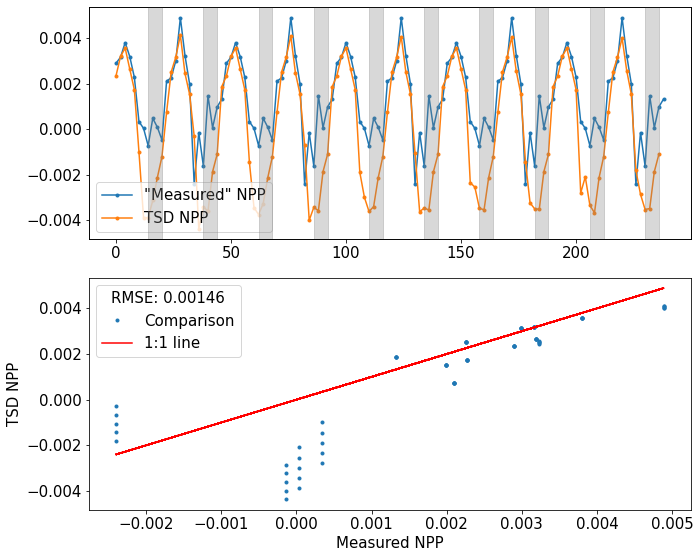

In [33]:
# get tsd components
tsd_df=run_STL(impute_df, 'with_missing')
# calculate hourly growth by exponential growth and maintain correct order
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
# calculate hourly growth by centered diff
# tsd_df['hourly_growth']=centered_diff(tsd_df, 'diel')
# calculate hourly productivity
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')
## compare against NPP measurements
# calculate RMSE for day values only
days_only=tsd_df.loc[tsd_df['par']>0]
# skip missing values
rmse=mean_squared_error(days_only.NPP.values[:-1], days_only.productivity.values[:-1], squared=False)
print(f'RMSE: {np.round(rmse,5)}')

#### Plot results ####
# plot NPP time series
fig,axs=plt.subplots(figsize=(10,8),nrows=2)
# plot original NPP and TSD estimated NPP
axs[0].plot(tsd_df['hour'],tsd_df['NPP'],marker='.',label='"Measured" NPP')
axs[0].plot(tsd_df['hour'],tsd_df['productivity'],marker='.',label='TSD NPP')
# plot night and day
twinax=axs[0].twinx()
plot_night_day(twinax, ylims=(0,0.2))
axs[0].legend()

# plot comparison of day productivity values
axs[1].plot(days_only['NPP'],days_only['productivity'],marker='.',linestyle='',label='Comparison')
axs[1].plot(days_only['NPP'],days_only['NPP'],label='1:1 line',c='r',marker='')
# make axis labels
axs[1].set_xlabel('Measured NPP')
axs[1].set_ylabel('TSD NPP')
axs[1].legend(title=f'RMSE: {np.round(rmse,5)}')

plt.tight_layout()

### Run moving block bootstrapping (MBB) on models to get uncertainty values

1. Get residual values
2. Separate residuals into _l_ length blocks
3. Randomly draw with resampling to create new time series of residuals
4. Combine with seasonal and trend components to generate new synthetic time series
5. Calculate new productivity values from synthetic time series
6. Repeat **_n_** times to get distribution of error

#### References
- Medium [guide](https://medium.com/@daydreamersjp/bootstrapping-on-time-series-data-moving-block-bootstrap-79aaf6648aec)
- Bergmeier et al. [slides](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cbergmeir.com/talks/bergmeir2014ISF_slides.pdf)
- Medium [tutorial (with paywall)](https://archive.ph/LSshc)


In [103]:
from arch.bootstrap import MovingBlockBootstrap
from numpy.random import standard_normal
from numpy.random import RandomState
from arch.bootstrap import optimal_block_length


## apply mbb to residuals of STL decomposition
mbb_df=tsd_df.set_index('hour')
data=mbb_df.resid.values
# try mbb of block length period+1 (25)
period=13
mbb=MovingBlockBootstrap(period, data, random_state=rs)

# grab synthetic datasets in each bootstrap
mbb_data=[]

for data in mbb.bootstrap(100):
    # grab blocked residual values
    new_resid=data[0][0]
    # generate synthetic ts from trend and diel components
    new_ts=new_resid*mbb_df.trend*mbb_df.diel
    mbb_data.append(new_ts)

Text(0.5, 1.0, '100x Bootstrapped STL Decomposition')

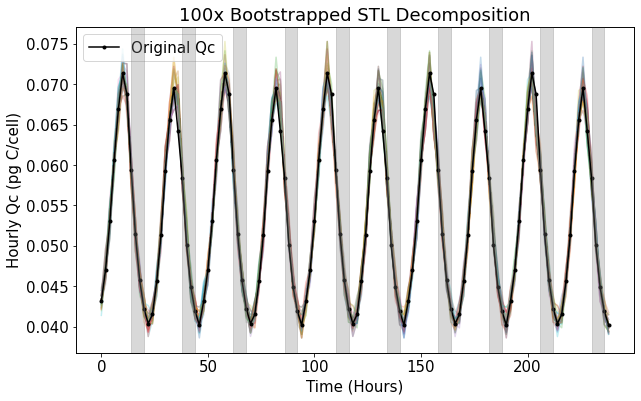

In [104]:
# make plot with bootstrapped results
fig,axs=plt.subplots(figsize=(10,6))
for line in mbb_data:
    axs.plot(line, alpha=0.25)
axs.plot(mbb_df.Qc_hour, c='k', label='Original Qc', marker='.')
twinax=axs.twinx()
plot_night_day(twinax, ylims=(0.04, 0.075))
axs.set_xlabel('Time (Hours)')
axs.set_ylabel('Hourly Qc (pg C/cell)')
axs.legend()
axs.set_title('100x Bootstrapped STL Decomposition')

### Perform time series train-test split and blocked cross validation
- Split time series data into training and testing
- Perform k-fold cross validation on varying blocks

**References**
- TS CV [blog post](https://goldinlocks.github.io/Time-Series-Cross-Validation/)
- Netpune AI [tutorial](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
- Medium [blog post ](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

In [ ]:
# helper function to 
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) #+ ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [45]:
# code from reference listed above
## class to define blocked split for training and testing data for time series CV
class BlockingTimeSeriesSplit():
    # initialize object
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    # class function to return # splits
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    # function to create blocked splits by works by adding margins at two positions. The first is between the 
    # training and validation folds in order to prevent the model from observing lag values which are used twice, 
    # once as an estimator (regressor) and another as a response. The second is between the folds used at 
    # each iteration in order to prevent the model from memorizing patterns from one iteration to the next.
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        # get size of each split
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        # split evenly between training and testing
        margin = 0
        # get indices of data for each split 
        for i in range(self.n_splits):
            # set beginning and end of split
            start = i * k_fold_size
            stop = start + k_fold_size
            # get middle of split to start testing
            mid = int(0.5 * (stop - start)) + start
            # pause function to return splits for training and testing
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# visualize split for normal time series split and blocking
cvs = [TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
        
plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# create time series split object
tscv = TimeSeriesSplit(n_splits = 4)
# set error metrics
rmse = []
# run grab training indices from truth data
NPP_truth=tsd_df.NPP.values
# for train_index, test_index in tscv.split(cross_validation):
#     cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
#     arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
#     predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [43]:
counter=0
for train_index, test_index in tscv.split(NPP_truth):
    print(counter)
    print(f'train: {train_index}')
    print(f'test: {test_index}')
    counter+=1

0
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
1
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
2
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
3
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 